In [1205]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

In [1206]:
train = pd.read_csv("resources/train.csv")
test = pd.read_csv("resources/test.csv")

In [1207]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [1208]:
train.columns[train.isna().any()]

Index(['education', 'previous_year_rating'], dtype='object')

<Axes: ylabel='previous_year_rating'>

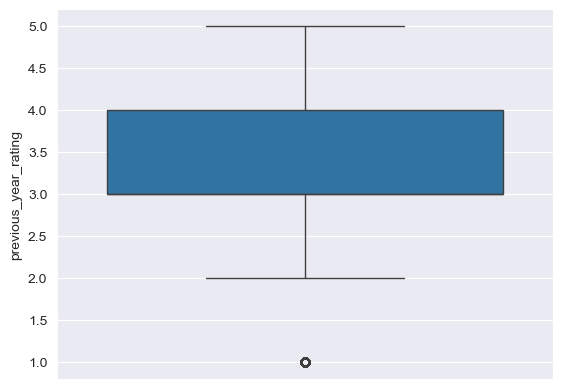

In [1209]:
sns.boxplot(train['previous_year_rating'])

In [1210]:
train.isna().sum()[train.isna().sum() > 0]

education               2409
previous_year_rating    4124
dtype: int64

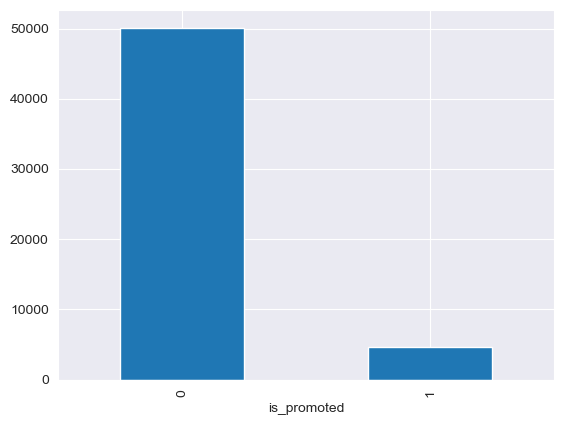

In [1211]:
train.is_promoted.value_counts().plot(kind='bar')
plt.show()

<Axes: ylabel='count'>

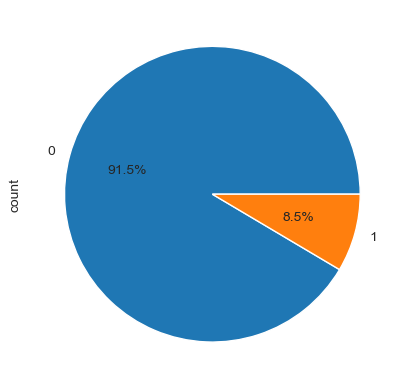

In [1212]:
train.is_promoted.value_counts().plot(kind='pie', autopct='%1.1f%%')

<Axes: xlabel='no_of_trainings', ylabel='avg_training_score'>

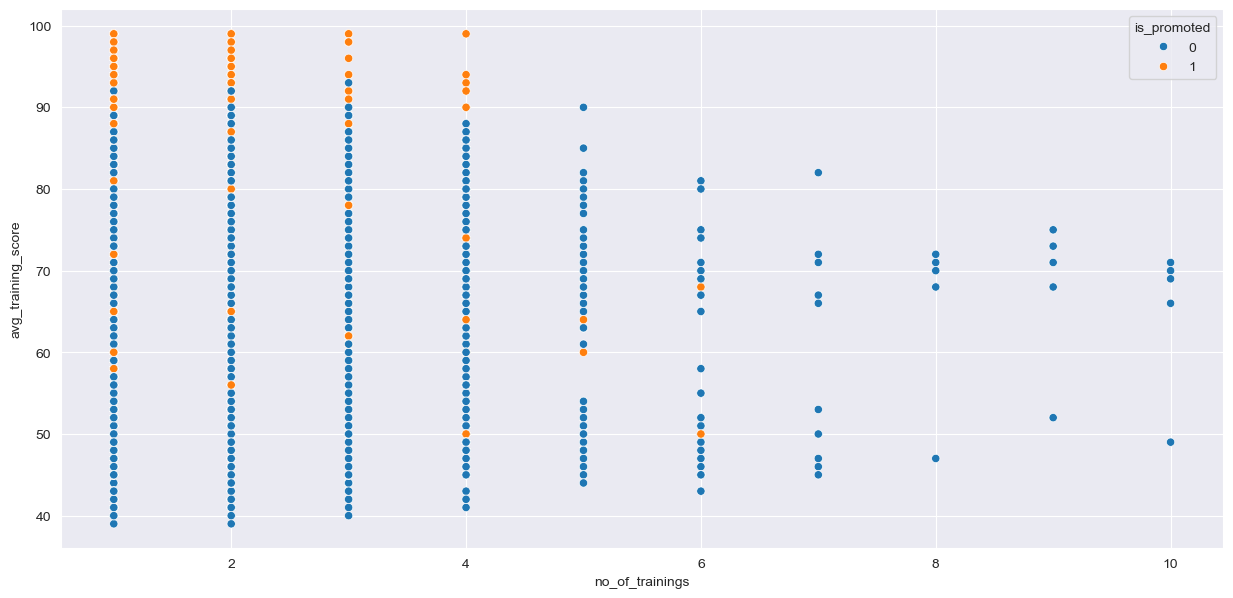

In [1213]:
plt.figure(figsize = (15,7))
sns.scatterplot(x = 'no_of_trainings', y = 'avg_training_score', data = train, hue = 'is_promoted')

In [1214]:
for df in [train, test]:
    # Standardize labels
    df['education_score'] = df['education'].replace({'Bachelor\'s':1,'Master\'s & above':2,'Below Secondary':0})
    df['recruitment_channel_score'] = df['recruitment_channel'].replace({'sourcing':1,'other':0,'referred':2})
    df['department_score'] = df['department'].replace({'Sales & Marketing':1,'Operations':2,'Procurement':3,'Technology':4,'Analytics':5,'R&D':6,'Finance':7,'HR':8,'Legal':9})
    df['gender_score'] = df['gender'].replace({'m':1,'f':0})
    df['high_performer'] = df['KPIs_met >80%'] * df['awards_won?']
    df['previous_year_rating'].fillna(0, inplace=True)
    df['is_new_joiner'] = np.where(df['previous_year_rating'] == 0, 1, 0)
    

In [1215]:
train

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,education_score,recruitment_channel_score,department_score,gender_score,high_performer,is_new_joiner
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,2.0,1,1,0,0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,1.0,0,2,1,0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,1.0,1,1,1,0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,1.0,0,1,1,0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,1.0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0,1.0,1,4,1,0,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0,2.0,0,2,0,0,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0,1.0,0,5,1,0,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0,NaN,1,1,1,0,0


In [1216]:
test

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,education_score,recruitment_channel_score,department_score,gender_score,high_performer,is_new_joiner
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,0.0,1,1,0,77,1.0,1,4,1,0,1
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51,1.0,0,8,0,0,0
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47,1.0,0,1,1,0,0
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65,1.0,0,3,0,0,0
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61,1.0,1,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,53478,Legal,region_2,Below Secondary,m,sourcing,1,24,3.0,1,0,0,61,0.0,1,9,1,0,0
23486,25600,Technology,region_25,Bachelor's,m,sourcing,1,31,3.0,7,0,0,74,1.0,1,4,1,0,0
23487,45409,HR,region_16,Bachelor's,f,sourcing,1,26,4.0,4,0,0,50,1.0,1,8,0,0,0
23488,1186,Procurement,region_31,Bachelor's,m,sourcing,3,27,0.0,1,0,0,70,1.0,1,3,1,0,1


In [1217]:
num_cols = train.drop(['employee_id','length_of_service'], axis=1).select_dtypes(include = np.number).columns.tolist()
num_cols

['no_of_trainings',
 'age',
 'previous_year_rating',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score',
 'is_promoted',
 'education_score',
 'recruitment_channel_score',
 'department_score',
 'gender_score',
 'high_performer',
 'is_new_joiner']

In [1218]:
cat_cols = train.drop(['department','education','gender','recruitment_channel','region'], axis=1).select_dtypes(include = 'object').columns.tolist()
cat_cols

[]

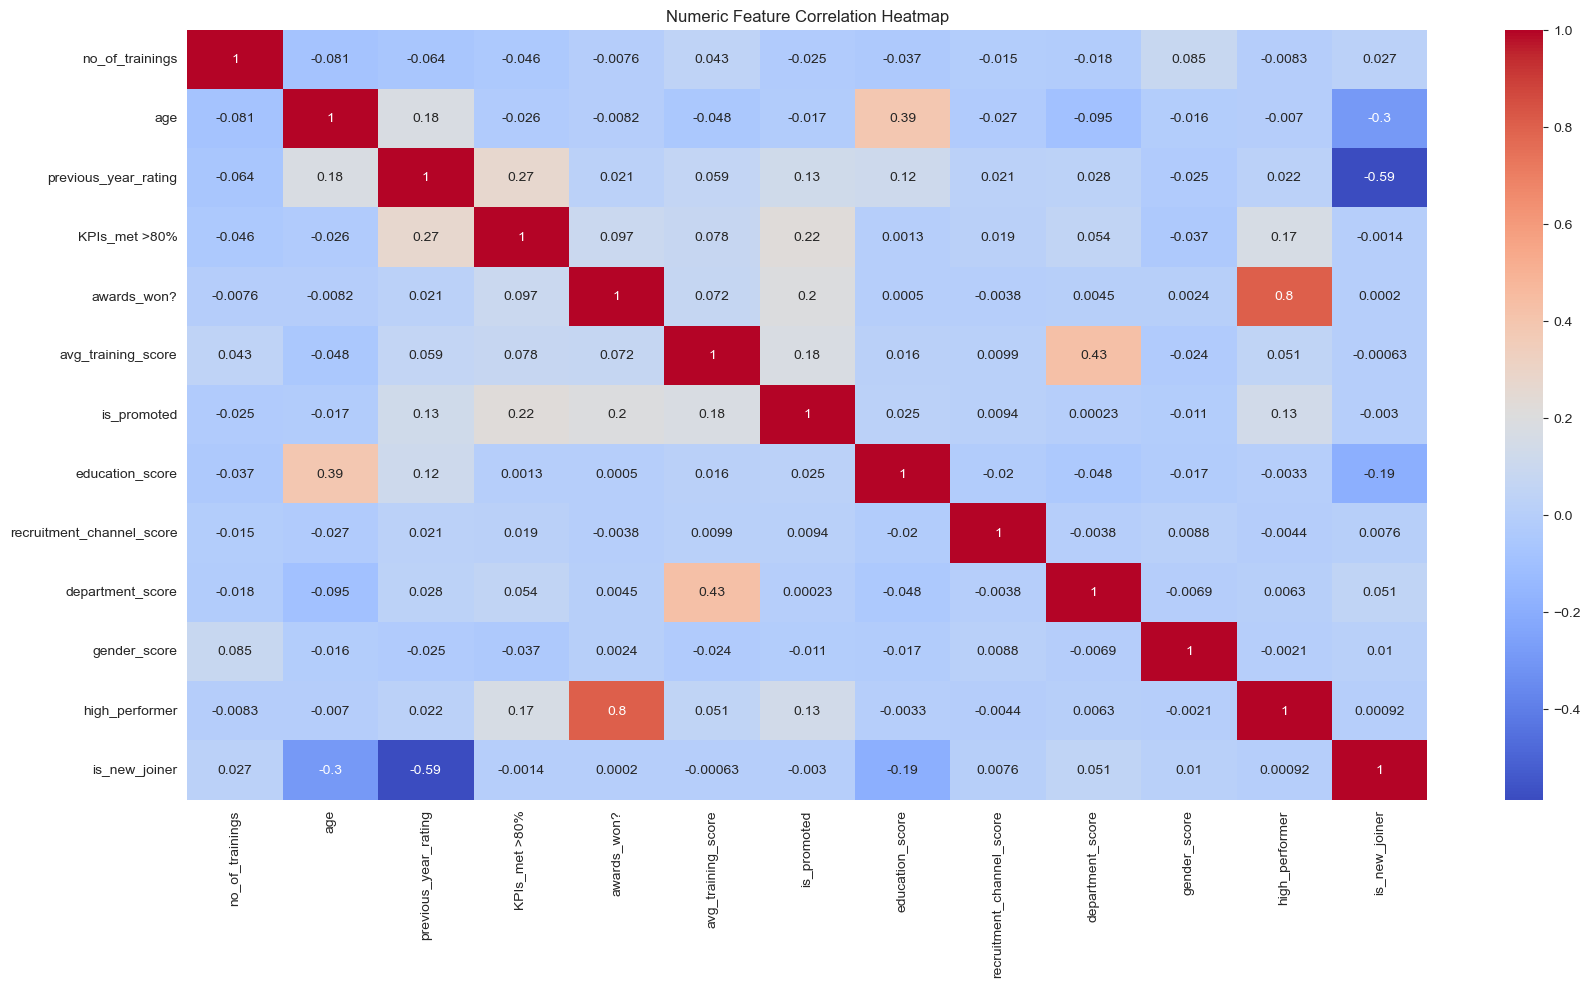

In [1219]:
plt.figure(figsize=(20,10))
sns.heatmap(train[num_cols].corr(), cmap='coolwarm', annot=True)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

In [1220]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
categoric_cols = train.select_dtypes(include='object').columns.tolist()

In [1221]:
def input_missing_values(df, categoric_cols, numeric_cols):
  le_dict = {}

  for col in categoric_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

  for col in df.columns:
    if df[col].isna().sum() > 0:
      print(f"Inputing Missing values in {col}")
      known = df[df[col].notna()]
      missing = df[df[col].isna()]

      X_train_imp = known.drop(col,axis = 1)
      y_train_imp = known[col]

      X_missing_imp = missing.drop(col,axis = 1)

      if col in numeric_cols:
        model_imp = DecisionTreeRegressor(random_state =42)
      else:
        model_imp = DecisionTreeClassifier(random_state=42)

      model_imp.fit(X_train_imp,y_train_imp)
      df.loc[df[col].isna(),col] = model_imp.predict(X_missing_imp)
      print("All missing values have been imputed using Decision Tree")

In [1222]:
input_missing_values(train, categoric_cols, numeric_cols)
input_missing_values(test, categoric_cols, numeric_cols)

Inputing Missing values in education_score
All missing values have been imputed using Decision Tree
Inputing Missing values in education_score
All missing values have been imputed using Decision Tree


In [1223]:
train.isna().sum()

employee_id                  0
department                   0
region                       0
education                    0
gender                       0
recruitment_channel          0
no_of_trainings              0
age                          0
previous_year_rating         0
length_of_service            0
KPIs_met >80%                0
awards_won?                  0
avg_training_score           0
is_promoted                  0
education_score              0
recruitment_channel_score    0
department_score             0
gender_score                 0
high_performer               0
is_new_joiner                0
dtype: int64

In [1224]:
test.isna().sum()

employee_id                  0
department                   0
region                       0
education                    0
gender                       0
recruitment_channel          0
no_of_trainings              0
age                          0
previous_year_rating         0
length_of_service            0
KPIs_met >80%                0
awards_won?                  0
avg_training_score           0
education_score              0
recruitment_channel_score    0
department_score             0
gender_score                 0
high_performer               0
is_new_joiner                0
dtype: int64

In [1225]:
train

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,education_score,recruitment_channel_score,department_score,gender_score,high_performer,is_new_joiner
0,65438,7,31,2,0,2,1,35,5.0,8,1,0,49,0,2.0,1,1,0,0,0
1,65141,4,14,0,1,0,1,30,5.0,4,0,0,60,0,1.0,0,2,1,0,0
2,7513,7,10,0,1,2,1,34,3.0,7,0,0,50,0,1.0,1,1,1,0,0
3,2542,7,15,0,1,0,2,39,1.0,10,0,0,50,0,1.0,0,1,1,0,0
4,48945,8,18,0,1,0,1,45,3.0,2,0,0,73,0,1.0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,8,5,0,1,2,1,48,3.0,17,0,0,78,0,1.0,1,4,1,0,0
54804,74592,4,19,2,0,0,1,37,2.0,6,0,0,56,0,2.0,0,2,0,0,0
54805,13918,0,0,0,1,0,1,27,5.0,3,1,0,79,0,1.0,0,5,1,0,0
54806,13614,7,33,3,1,2,1,29,1.0,2,0,0,45,0,2.0,1,1,1,0,0


In [1226]:
target_columns = ['is_promoted']
ignore_columns = ['employee_id', 'department', 'education', 'gender', 'recruitment_channel','region']

In [1227]:
X = train.drop(columns=ignore_columns + target_columns)
y = train[target_columns]

In [1228]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [1229]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((43846, 13), (10962, 13), (43846, 1), (10962, 1))

In [1230]:
num_cols.remove('is_promoted')

In [1231]:
model_pipeline = Pipeline(steps=[
    ('model', LogisticRegression())
])
model_pipeline

Pipeline(steps=[('model', LogisticRegression())])

In [1232]:
model_pipeline.fit(train_X, train_y)

Pipeline(steps=[('model', LogisticRegression())])

In [1233]:
model_pipeline.predict(test_X)

array([0, 0, 0, ..., 0, 0, 0])

In [1234]:
model_pipeline.predict_proba(test_X)

array([[0.8233206 , 0.1766794 ],
       [0.94426597, 0.05573403],
       [0.97792918, 0.02207082],
       ...,
       [0.86702068, 0.13297932],
       [0.70457334, 0.29542666],
       [0.94562492, 0.05437508]])

In [1235]:
def evaluate_model(model, train_X, train_y, test_X, test_y):
    
    train_preds = model.predict(train_X)
    test_preds = model.predict(test_X)

    print("Training Accuracy:", roc_auc_score(train_y, train_preds))
    print("Testing Accuracy:", roc_auc_score(test_y, test_preds))
    print("\nClassification Report:\n", classification_report(test_y, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(test_y, test_preds))

In [1236]:
evaluate_model(model_pipeline, train_X, train_y, test_X, test_y)

Training Accuracy: 0.5490185261129575
Testing Accuracy: 0.5566899832503253

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     10028
           1       0.57      0.12      0.20       934

    accuracy                           0.92     10962
   macro avg       0.75      0.56      0.58     10962
weighted avg       0.89      0.92      0.89     10962

Confusion Matrix:
 [[9941   87]
 [ 820  114]]


In [1237]:
submission = pd.read_csv("resources/sample_submission.csv")
submission.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [1238]:
submission['is_promoted'] = model_pipeline.predict(test.drop(columns=ignore_columns))
submission.to_csv("resources/submission_Logistic.csv", index=False)

In [1239]:
param_grid = [
    {
        'model' : [XGBClassifier()],
        'model__objective' : ['binary:logistic'],
        'model__eval_metric' : ['auc'],
        'model__n_estimators' : [700],
        'model__learning_rate' : [0.07],
        'model__max_depth' : [4],
        'model__min_child_weight' : [5],
        'model__gamma' : [1],
        'model__subsample' : [0.8],
        'model__colsample_bytree' : [0.8],
        'model__alpha' : [0.5],
        'model__lambda' : [5],
        'model__n_jobs' : [-1],
        'model__random_state' : [24]
    }
]

In [1240]:
gridSearch = GridSearchCV(estimator=model_pipeline,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          cv=2)

In [1241]:
overSampler = RandomOverSampler()

In [1242]:
train_X_OS, train_y_OS = overSampler.fit_resample(train_X, train_y)

In [1243]:
gridSearch.fit(train_X_OS, train_y_OS)

GridSearchCV(cv=2, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             param_grid=[{'model': [XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  device=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  feature_weights=None,
                                                  gamma...
                          'model__alpha': [0.5],
                          'model__colsample_bytree': [0.8],
                          'model__eval_metric': ['auc'], 'model__gamma': [1],
                          'model__lambda': [5], 'model__learning_rate': [0.07],
                          'model__max_depth': [4],
                          'model__min_child_weight': [5],
                          'model__n_estimators': [700], 'model__n_jobs': [-1],
                          'model__objective': ['binary:logistic'],
                          'model__random_state': [24],
                          'model__subsample': [0.8]}],
             scoring='roc_auc')

In [1244]:
gridSearch.best_params_

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, ...),
 'model__alpha': 0.5,
 'model__colsample_bytree': 0.8,
 'model__eval_metric': 'auc',
 'model__gamma': 1,
 'model__lambda': 5,
 'model__learning_rate': 0.07,
 'model__max_depth': 4,
 'model__min_child_weight': 5,
 'mode

In [1245]:
gridSearch.best_estimator_

Pipeline(steps=[('model',
                 XGBClassifier(alpha=0.5, base_score=None, booster=None,
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.8,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, feature_weights=None,
                               gamma=1, grow_policy=None, importance_type=None,
                               interaction_constraints=None, lambda=5,
                               learning_rate=0.07, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=700, ...))])

In [1246]:
res_df = pd.DataFrame(gridSearch.cv_results_)

In [1247]:
pd.set_option('display.max_colwidth', 1000)
res_df[['param_model','params', 'mean_test_score', 'rank_test_score']]

,param_model,params,mean_test_score,rank_test_score
0,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=None,\n n_jobs=None, num_parallel_tree=None, ...)","{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'model__alpha': 0.5, 'model__colsample_bytree': 0.8, 'model__eval_metric': 'auc', 'model__gamma': 1, 'model__lambda': 5, 'model__learning_rate': 0.07, 'model__max_depth': 4, 'model__min_child_weight': 5, 'model__n_estimators...",0.928569,1


In [1248]:
new_model = gridSearch.best_estimator_

In [1249]:
evaluate_model(new_model, train_X, train_y, test_X, test_y)

Training Accuracy: 0.8555236152912179
Testing Accuracy: 0.8125682777729852

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85     10028
           1       0.25      0.87      0.39       934

    accuracy                           0.76     10962
   macro avg       0.62      0.81      0.62     10962
weighted avg       0.92      0.76      0.81     10962

Confusion Matrix:
 [[7568 2460]
 [ 121  813]]


Metrics calculated for various thresholds.


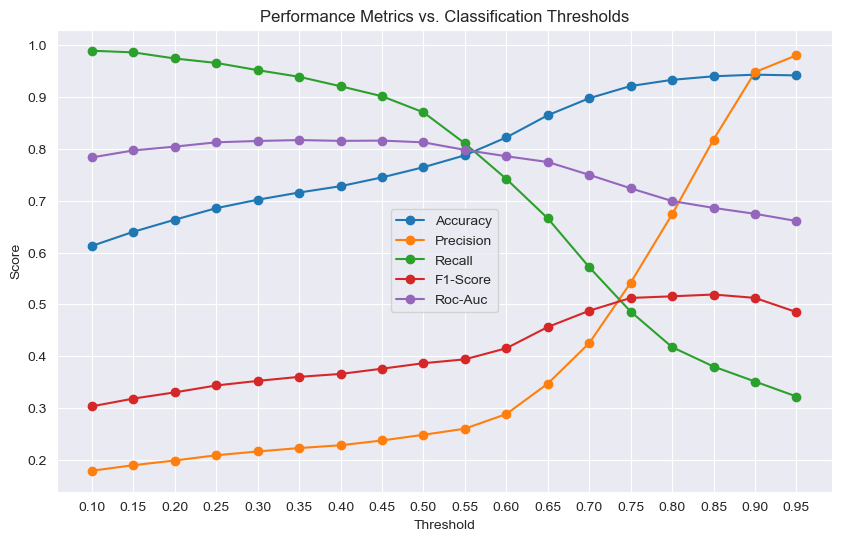

Plotting of performance metrics against classification thresholds is complete.


In [1250]:
# Generate a range of classification thresholds
thresholds = np.arange(0.1, 1.0, 0.05)

# Get predicted probabilities for the test set
y_pred_proba = new_model.predict_proba(test_X)[:, 1]

# Initialize lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Iterate through each threshold and calculate metrics
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    accuracy_scores.append(accuracy_score(test_y, y_pred_threshold))
    precision_scores.append(precision_score(test_y, y_pred_threshold, zero_division=0))
    recall_scores.append(recall_score(test_y, y_pred_threshold, zero_division=0))
    f1_scores.append(f1_score(test_y, y_pred_threshold, zero_division=0))
    roc_auc_scores.append(roc_auc_score(test_y, y_pred_threshold))

print("Metrics calculated for various thresholds.")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label='Accuracy', marker='o')
plt.plot(thresholds, precision_scores, label='Precision', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
plt.plot(thresholds, roc_auc_scores, label='Roc-Auc', marker='o')

plt.title('Performance Metrics vs. Classification Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.show()

print('Plotting of performance metrics against classification thresholds is complete.')

In [1251]:
y_probs = new_model.predict_proba(test.drop(columns=ignore_columns))[:,1]
custom_threshold = 0.80
submission['is_promoted'] = (y_probs >= custom_threshold).astype(int)
submission.to_csv("resources/submission_XGB.csv", index=False)

In [1252]:
import joblib
joblib.dump(new_model, 'employee_promotion_model.pkl')

['employee_promotion_model.pkl']